# Imports

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, Conv2D, MaxPooling2D, TimeDistributed
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import *

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

In [10]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

Amount of GPUs available: 4


# Load data

In [11]:
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed/all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'H', combine_all_dwellings=False)

# Get all the data out of datetime
# Could also get holiday data: https://stackoverflow.com/questions/29688899/pandas-checking-if-a-date-is-a-holiday-and-assigning-boolean-value
df['hour'] = df.index.hour #create column containing the hour
df['dayofweek'] = df.index.dayofweek
df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)

df['month'] = df.index.month
#df['week'] = df.index.week
#df['day'] = df.index.day
#df['year'] = df.index.year

df['month_end'] = df.index.is_month_end
df['month_start'] = df.index.is_month_start
df['quarter_end'] = df.index.is_quarter_end
df['quarter_start'] = df.index.is_quarter_start



100%|██████████| 51/51 [00:00<00:00, 88.46it/s]


In [12]:
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,gasPower,dwelling,hour,dayofweek,season,month,month_end,month_start,quarter_end,quarter_start
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-07 16:00:00,625.401001,0.0,359.501007,0.0,383.994446,0.0,307.441010,288.200012,0.0,5.418334,...,0.000000,P01S01W7548,16,1,2,3,False,False,False,False
2017-03-07 17:00:00,625.679993,0.0,359.501007,0.0,277.722229,0.0,307.441010,285.866669,0.0,4.593333,...,0.000000,P01S01W7548,17,1,2,3,False,False,False,False
2017-03-07 18:00:00,625.820984,0.0,359.501007,0.0,143.624283,0.0,307.441010,286.633331,0.0,3.783333,...,0.000000,P01S01W7548,18,1,2,3,False,False,False,False
2017-03-07 19:00:00,625.963013,0.0,359.501007,0.0,143.376038,0.0,307.441010,278.783325,0.0,2.741667,...,0.000000,P01S01W7548,19,1,2,3,False,False,False,False
2017-03-07 20:00:00,626.458984,0.0,359.501007,0.0,499.144440,0.0,307.544006,245.816666,0.0,3.418333,...,0.102997,P01S01W7548,20,1,2,3,False,False,False,False


Saving heatmap


<Figure size 432x288 with 0 Axes>

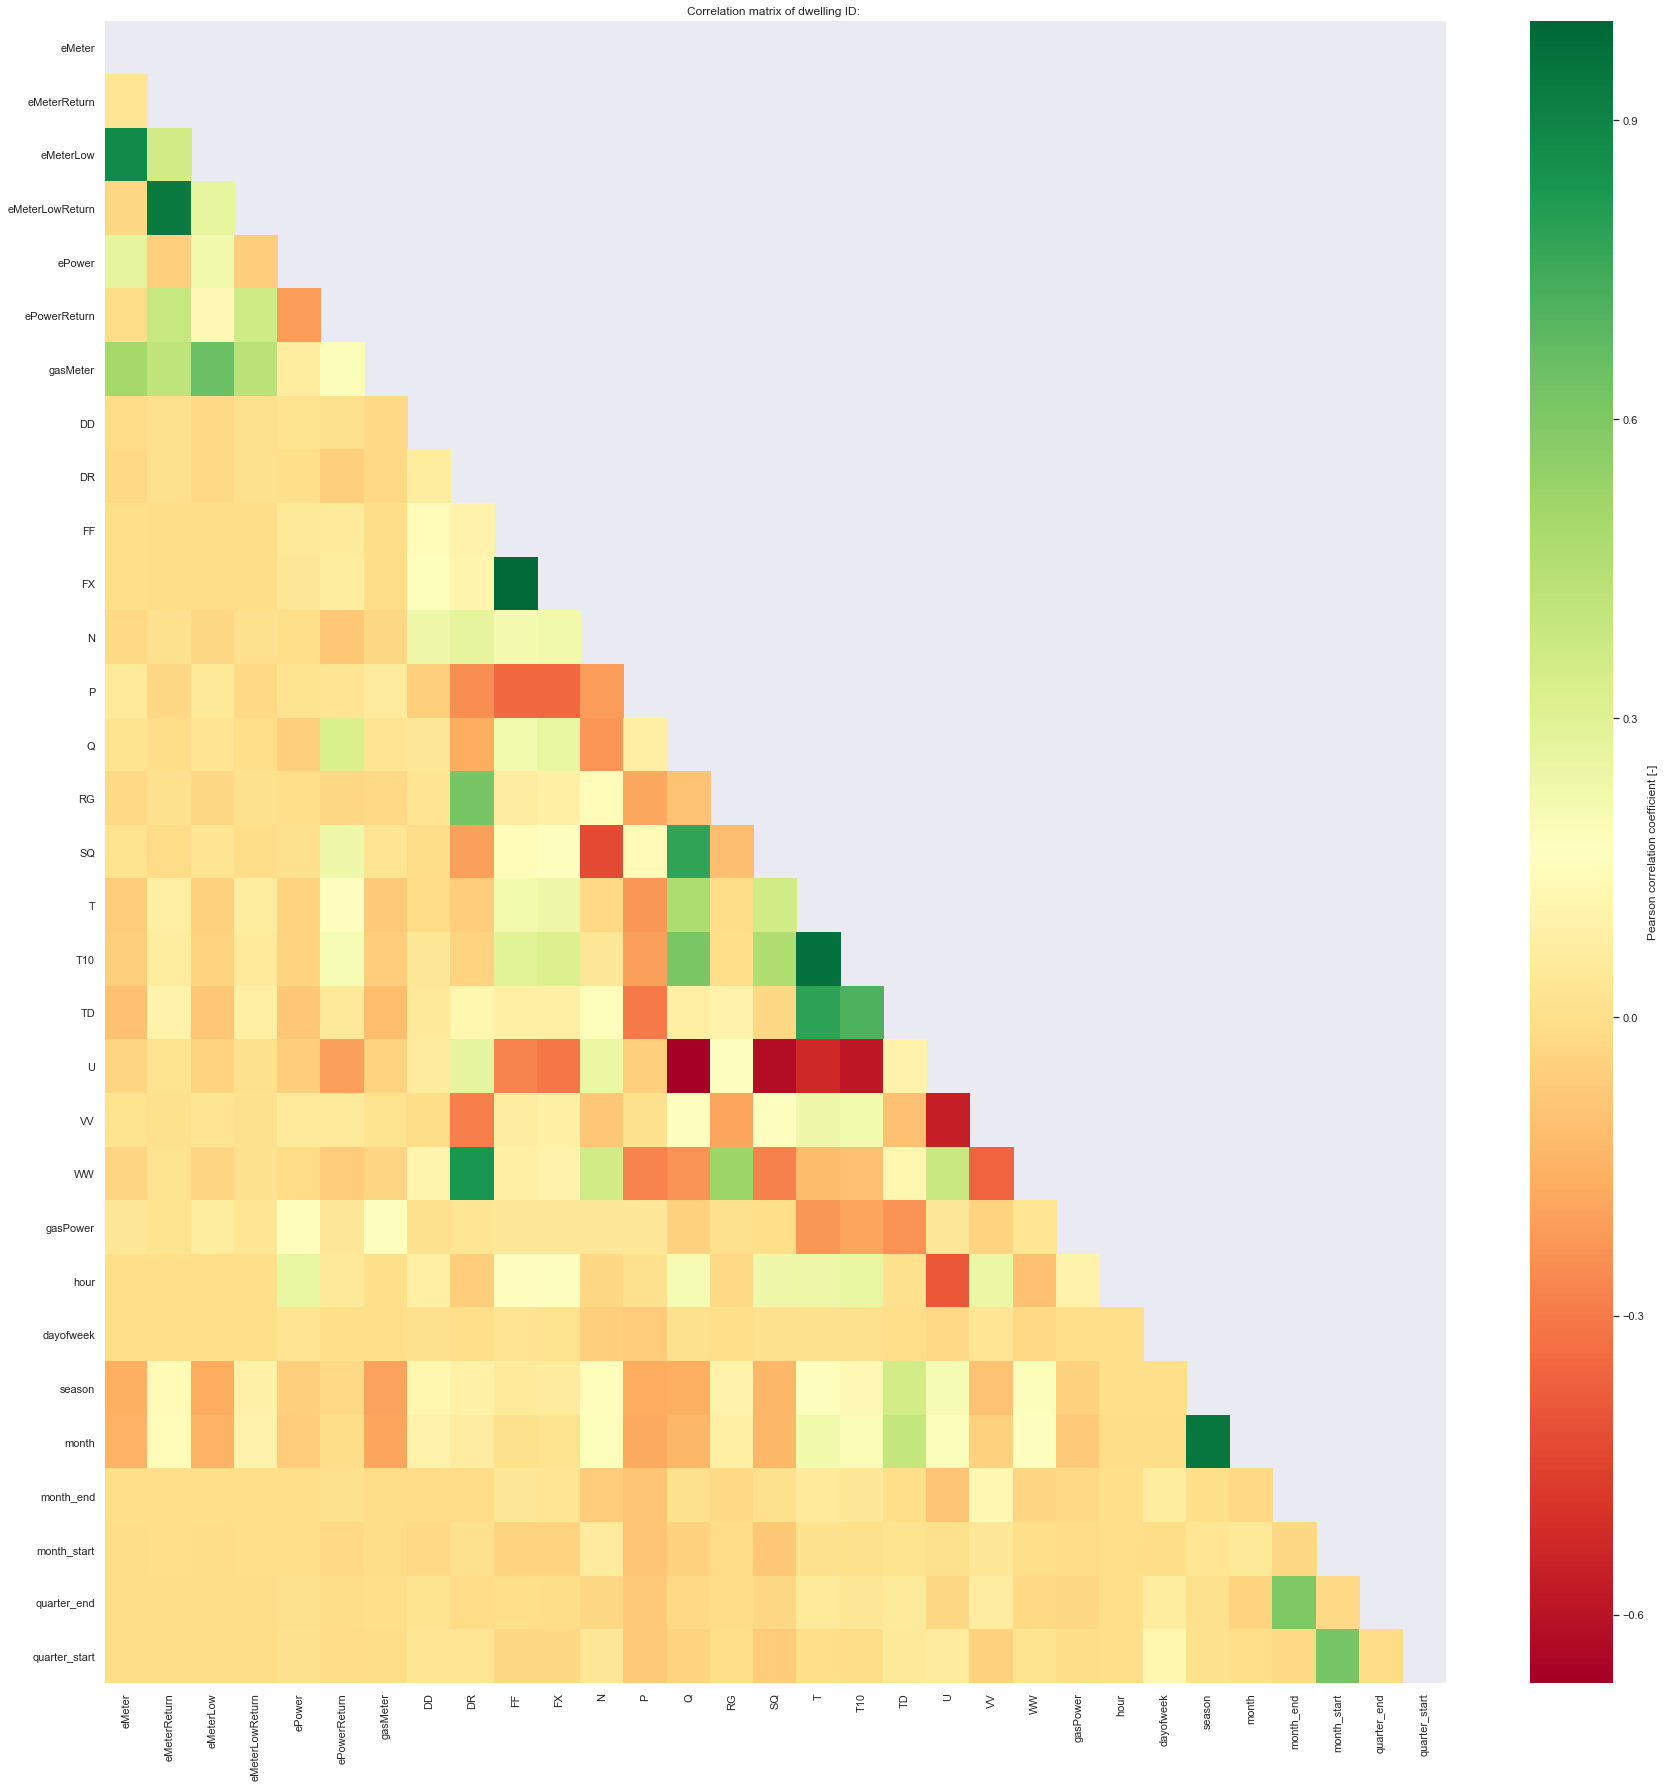

In [13]:
fig = create_corr_matrix(df, '', False)

# Select data to use

In [14]:
data = df
#data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'dwelling'], axis=1) # Not needed
#data = data.drop(['dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

#data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower
data = data.drop(['ePowerReturn'], axis=1)


# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

data.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,gasMeter,FF,RG,T,gasPower,dwelling,hour,dayofweek,season,month,month_end,month_start,quarter_end,quarter_start
datetime,,,,,,,,,,,,,,,,,,,
2017-03-07 16:00:00,625.401001,0.0,359.501007,0.0,383.994446,307.441010,5.418334,0.0,9.116667,0.000000,P01S01W7548,16,1,2,3,False,False,False,False
2017-03-07 17:00:00,625.679993,0.0,359.501007,0.0,277.722229,307.441010,4.593333,0.0,7.866667,0.000000,P01S01W7548,17,1,2,3,False,False,False,False
2017-03-07 18:00:00,625.820984,0.0,359.501007,0.0,143.624283,307.441010,3.783333,0.0,7.066667,0.000000,P01S01W7548,18,1,2,3,False,False,False,False
2017-03-07 19:00:00,625.963013,0.0,359.501007,0.0,143.376038,307.441010,2.741667,0.0,6.616667,0.000000,P01S01W7548,19,1,2,3,False,False,False,False
2017-03-07 20:00:00,626.458984,0.0,359.501007,0.0,499.144440,307.544006,3.418333,0.0,6.616667,1.029968,P01S01W7548,20,1,2,3,False,False,False,False


Saving heatmap
Len of data:  105438


<Figure size 432x288 with 0 Axes>

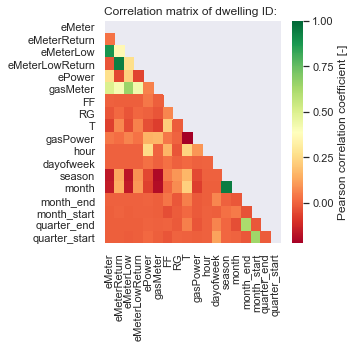

In [15]:
fig = create_corr_matrix(data, '', False, size=(5,5))

print('Len of data: ', len(data))

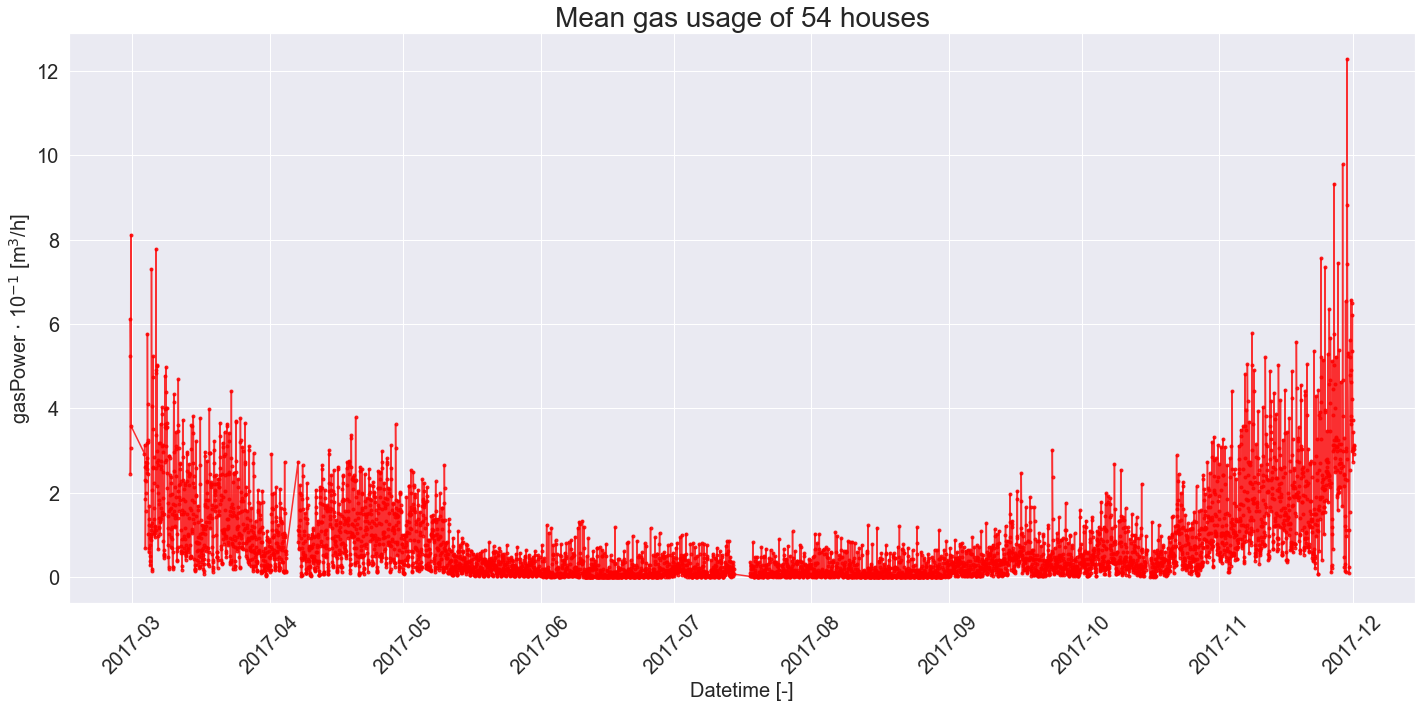

In [31]:
plt.figure(figsize=(20,10))

plt.plot(data.index, data['gasPower'], '.-', color='red', label='Original data', alpha=0.8)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % (magnitude), fontsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.title('Mean gas usage of 54 houses', fontsize=28)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

# Preprocessing

In [32]:
"""
Add a copy of gasPower column, so previous gasPower values are also in X_reshaped
"""
data['gasPower_copy'] = data['gasPower']

data.head()

,ePower,FF,RG,T,gasPower,gasPower_std,hour,dayofweek,season,month,month_end,month_start,quarter_end,quarter_start,gasPower_copy
datetime,,,,,,,,,,,,,,,
2017-02-28 12:00:00,308.321701,9.067500,0.0,5.183333,6.115723,0.085626,12,1,1,2,True,False,False,False,6.115723
2017-02-28 13:00:00,263.656273,8.684999,0.0,5.300000,5.238647,0.318250,13,1,1,2,True,False,False,False,5.238647
2017-02-28 14:00:00,181.913345,8.296667,0.0,5.283333,2.451172,0.041087,14,1,1,2,True,False,False,False,2.451172
2017-02-28 15:00:00,378.613129,6.918334,0.0,5.516667,3.065186,0.214238,15,1,1,2,True,False,False,False,3.065186
2017-02-28 16:00:00,332.392082,6.583333,0.0,5.433333,8.120117,0.014156,16,1,1,2,True,False,False,False,8.120117


In [33]:
#data = create_timeseries_history(data, columns_to_lookback=data.columns, n_lookback=5, dropnan=True)

In [34]:
data.columns

Index(['ePower', 'FF', 'RG', 'T', 'gasPower', 'gasPower_std', 'hour',
       'dayofweek', 'season', 'month', 'month_end', 'month_start',
       'quarter_end', 'quarter_start', 'gasPower_copy'],
      dtype='object')

# datetime info to categorical

In [35]:
"""
Ideally would want to one-hot-encode season/month also?
But this does not make sense if like 4 (one hot encoded) months are none existant in the training set?
In the end maybe one hot encode all the datetime info + one hot encode houses based on their groups (energy label, area etc.).
"""

#columns_to_cat = ['year', 'month', 'day', 'hour', 'dayofweek', 'season']
columns_to_cat = ['hour', 'dayofweek', 'season', 'month', 'month_end', 'month_start', 'quarter_end', 'quarter_start']
data[columns_to_cat] = data[columns_to_cat].astype('category') # change datetypes to category

data = pd.get_dummies(data, columns=columns_to_cat) # One hot encoding the categories
data.head()

,ePower,FF,RG,T,gasPower,gasPower_std,gasPower_copy,hour_0,hour_1,hour_2,...,month_11,month_12,month_end_False,month_end_True,month_start_False,month_start_True,quarter_end_False,quarter_end_True,quarter_start_False,quarter_start_True
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-28 12:00:00,308.321701,9.067500,0.0,5.183333,6.115723,0.085626,6.115723,0,0,0,...,0,0,0,1,1,0,1,0,1,0
2017-02-28 13:00:00,263.656273,8.684999,0.0,5.300000,5.238647,0.318250,5.238647,0,0,0,...,0,0,0,1,1,0,1,0,1,0
2017-02-28 14:00:00,181.913345,8.296667,0.0,5.283333,2.451172,0.041087,2.451172,0,0,0,...,0,0,0,1,1,0,1,0,1,0
2017-02-28 15:00:00,378.613129,6.918334,0.0,5.516667,3.065186,0.214238,3.065186,0,0,0,...,0,0,0,1,1,0,1,0,1,0
2017-02-28 16:00:00,332.392082,6.583333,0.0,5.433333,8.120117,0.014156,8.120117,0,0,0,...,0,0,0,1,1,0,1,0,1,0


# Preprocessing, data to lstm format

In [36]:
look_back = 5*24 # D -> 5, H -> 5*24
num_features = data.shape[1] - 1
output_dim = 1
test_size = 0.8 # This acctually is the train size, oops.
target_column = 'gasPower'

X_train, y_train, X_test, y_test = df_to_lstm_format(df=data, test_size=test_size, look_back=look_back, target_column=target_column, scale_X=True)
X_train.shape

(4961, 120, 60)

In [37]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train.shape

(4961, 120, 60, 1)

In [38]:
def mape(y_true, y_pred):
    import keras.backend as K
    """
    Returns the mean absolute percentage error.
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

def smape(y_true, y_pred):
    import keras.backend as K
    """
    Returns the Symmetric mean absolute percentage error.
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_pred - y_true) / ((K.abs(y_true) + K.abs(y_pred))))*100

In [71]:
"""
For info on batch normalization: https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
CuDNN.... Use GPU implementations of .... model, this speeds up the training.
"""

from keras.layers import InputLayer, ConvLSTM2D, Reshape, GRU, CuDNNLSTM, CuDNNGRU
from keras.layers.normalization import BatchNormalization

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

dropout = 0.2

# define CNN model

# define LSTM model
model = Sequential()

# Input shape: (samples, time, channels, rows, cols) see: https://keras.io/layers/recurrent/#convlstm2d
model.add(Conv2D(
        filters=8,
        kernel_size=(100, 50), #60, 30
        input_shape=input_shape,
        padding='same', kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(
        filters=8,
        kernel_size=(20, 20), # 20, 20
        input_shape=input_shape,
        padding='same', kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout))

#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

conv_output = model.output_shape
print(conv_output)

model.add(Reshape((conv_output[1], conv_output[2]*conv_output[3])))

# Input should be: (batch_size, timesteps, input_dim)
model.add(CuDNNGRU(16, return_sequences=False)) #32
model.add(LeakyReLU())
model.add(Dropout(dropout))

#model.add(Flatten())
#print('Flatten Output: ' , model.output_shape)

model.add(Dense(128*2*2))
model.add(LeakyReLU())
model.add(Dropout(dropout))

model.add(Dense(64*2*2))
model.add(LeakyReLU())
model.add(Dropout(dropout))

model.add(Dense(units=output_dim, kernel_initializer='TruncatedNormal'))


#print(model.summary())

multi_model = multi_gpu_model(model, gpus=num_gpu)

(None, 120, 60, 8)


# Learning rate finder

In [72]:
multi_model.compile(optimizer='adam', loss = ['mse'], metrics=[mape, smape, 'mse']) # Needs to have the same optimizer that will be used when fitting!

In [73]:
"""
Note that the learning rate finder is not made by me.
For the source see keijzer.py .
"""
bs = int(len(X_train)/50) # Batch size
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=bs)

multi_model.fit(X_train, y_train, callbacks=[lr_finder] )

## Plot LR informartion

## For some reason this influences the training by a lot. Not running the code and just using 'adam' performs better than applying the LR finder this way.

lr_finder.plot()

lr_finder.plot_smoothed_loss()

In [74]:
# Choose the highest learning rate where the loss is still improving by a lot
lr=1e-2

del multi_model # Make sure to have a 'fresh' model, so the fitting from LR finder has no influence.
multi_model = multi_gpu_model(model, gpus=num_gpu)

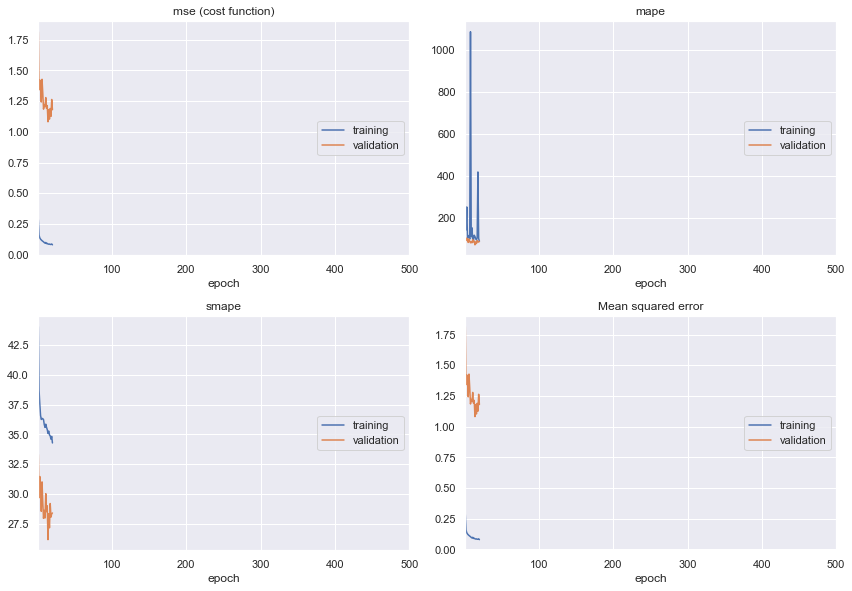

 - 10s - loss: 0.0802 - mape: 87.6736 - smape: 34.2802 - mean_squared_error: 0.0802 - val_loss: 1.1803 - val_mape: 87.4963 - val_smape: 28.4089 - val_mean_squared_error: 1.1803
Epoch 21/500


In [ ]:
"""
Look back , 5
nodes, 35

More only makes the model more complex and harder/slower to train
"""

epochs = 500 #135

# 0.05 0.9 0 True
#sgd = SGD(lr=lr, momentum=0.9, decay=0, nesterov=True) # 0.005
sgd = SGD(lr=lr)
adam = Adam(lr=lr)

epoch_size = 3

# For more info see: https://www.jeremyjordan.me/nn-learning-rate/
# Not applying it correctly? 19-11-2018 20.24
schedule = SGDRScheduler(min_lr=1e-3, # Pick the range where LR is ideal
                         max_lr=1e-1,
                         steps_per_epoch=np.ceil(epoch_size/bs),
                         lr_decay=0.9,
                         cycle_length=5,
                         mult_factor=1.5)

# compile & fit
multi_model.compile(optimizer='sgd', loss = ['mse'], metrics=[mape, smape, 'mse'])

early_stopping_monitor = EarlyStopping(patience=5000)


multi_model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_data=(X_test, y_test),
         verbose=2, callbacks=[PlotLossesKeras(), early_stopping_monitor, schedule])

# Create plot

In [59]:
y_preds = multi_model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it


1151/1151 [==============================] - 1s 1ms/step
FINISHED


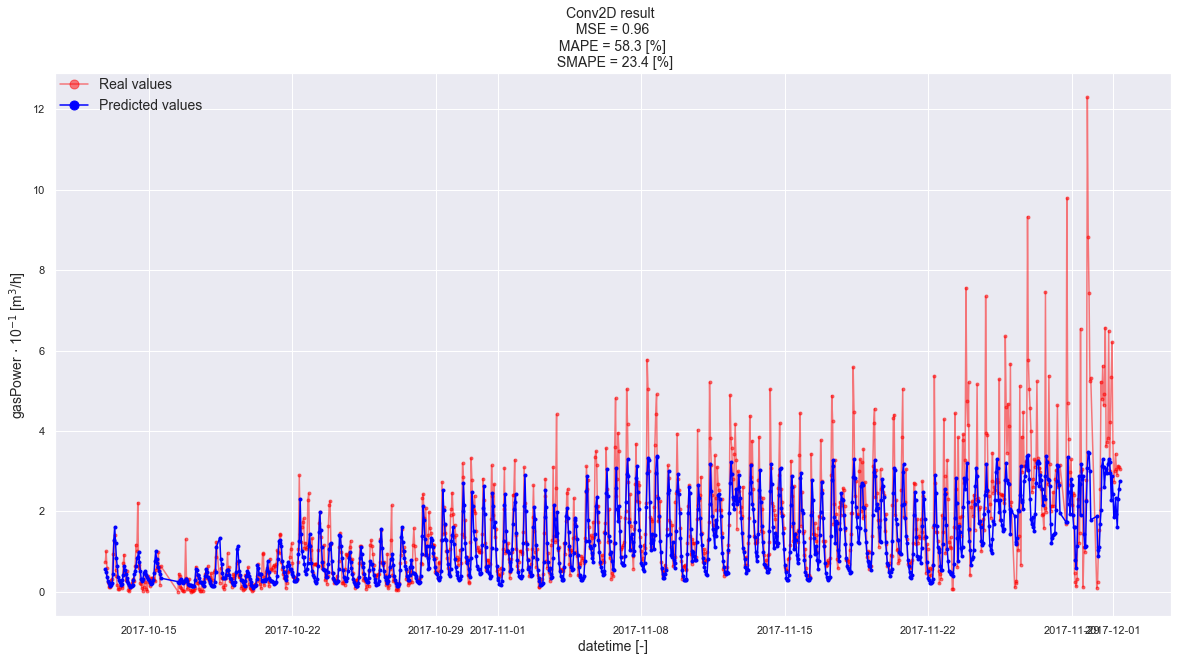

In [60]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_preds, '.-', color='blue', label='Predicted values')

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result, _ = multi_model.evaluate(X_test, y_test)

plt.title('Conv2D result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/LSTM result hourly.png', dpi=300)
print('FINISHED')

# Make the same plot, but downsample the results to a day

In [61]:
# Get results, put it in a dataframe

y_preds = multi_model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

# Make it a df to be able to downsample
datetime = x.index
print(datetime.shape)

y_preds = y_preds.reshape(y_preds.shape[0])
y_true = y_true.reshape(y_true.shape[0])

results = pd.DataFrame(y_true, y_preds) # For some reason y_true becomes the index
result = results.reset_index() # Ugly way to fix above problem
result.columns = ['y_pred', 'y_true']

result['datetime'] = datetime
result = result.set_index(['datetime'])

result.to_csv('model _results _data/CNN_predictions.csv')

result = result.resample('D').sum() # Resample data

result = result.dropna()

(1151,)


In [62]:
# Calculate evaluation metrics over the result

ytrue = result['y_true']
ypred = result['y_pred']
n = len(result)

mse_result = (1/n)*np.sum((ypred - ytrue)**2)
mape_result = (100/n) * np.sum(np.abs((ytrue - ypred) / ypred))
smape_result = (100/n) * np.sum( np.abs((ytrue - ypred)) / (np.abs(ytrue) + np.abs(ypred)) )

Text(0.5, 1.0, 'Conv2D result \n MSE = 113.21 \n MAPE = 27.2 [%] \n SMAPE = 11.7 [%]')

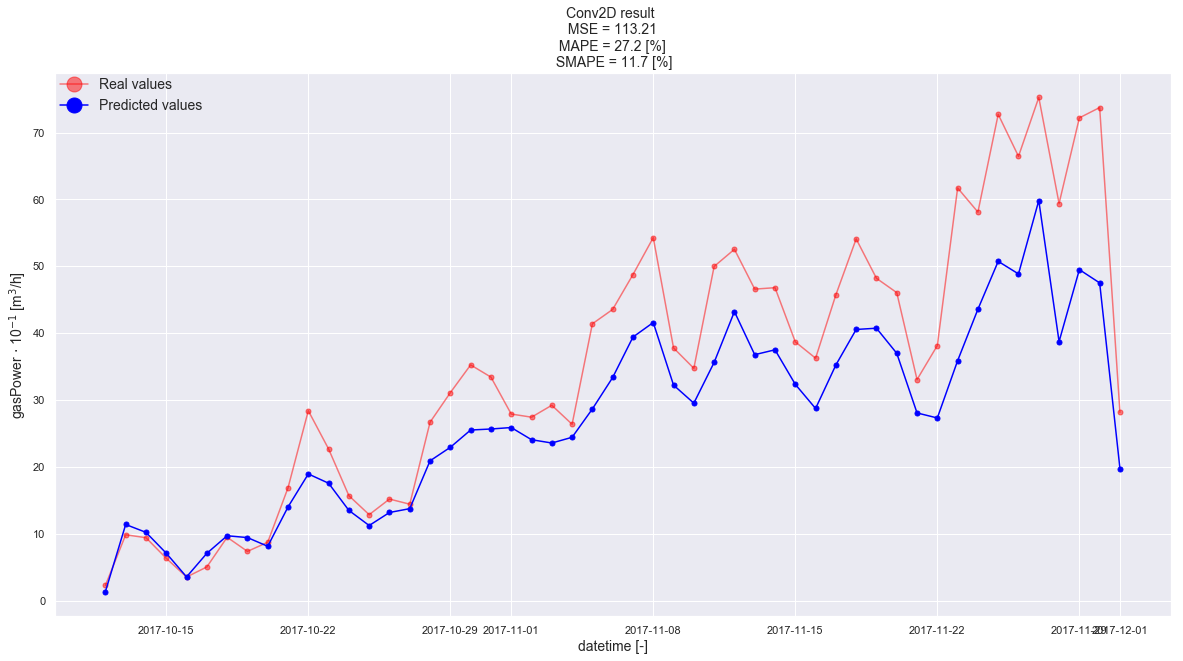

In [63]:
# Create plot
plt.figure(figsize=(20,10))
plt.plot(result.index, result['y_true'], '.-', color='red', label='Real values', alpha=0.5, ms=10) # ms is markersize
plt.plot(result.index, result['y_pred'], '.-', color='blue', label='Predicted values', ms=10)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

plt.title('Conv2D result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/LSTM result hourly resampled to daily by sum.png', dpi=300)

# Save the model

In [ ]:
model.save('model.h5')
model.save_weights('model_weights.h5')
print('FINISHED')

# Load the model

In [ ]:
from keras.models import load_model
model = load_model('model.h5') # Load the architecture
moel = model.load_weights('model_weights.h5') # Set the weights

model.compile(optimizer='adam', loss = ['mse'], metrics=[mape, smape]) # Compile it (could also set to multi_gpu before this)
print('FINISHED')

In [ ]:
model.summary()